<a href="https://colab.research.google.com/github/cheesecake37/Projects/blob/main/FRAM_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.stats import skew, kurtosis, norm , chi2
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf


assets = ['RELIANCE.NS', '^NSEI', 'INR=X', 'APOLLOTYRE.NS', 'GC=F']
asset_names = ['Reliance', 'Nifty 50', 'USD/INR', 'Apollo Tyres', 'Gold']

start_date = '2020-08-30'
end_date = '2025-05-11'
data = yf.download(assets, start=start_date, end=end_date)['Close']
data.columns = asset_names

/tmp/ipython-input-2-3449867649.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


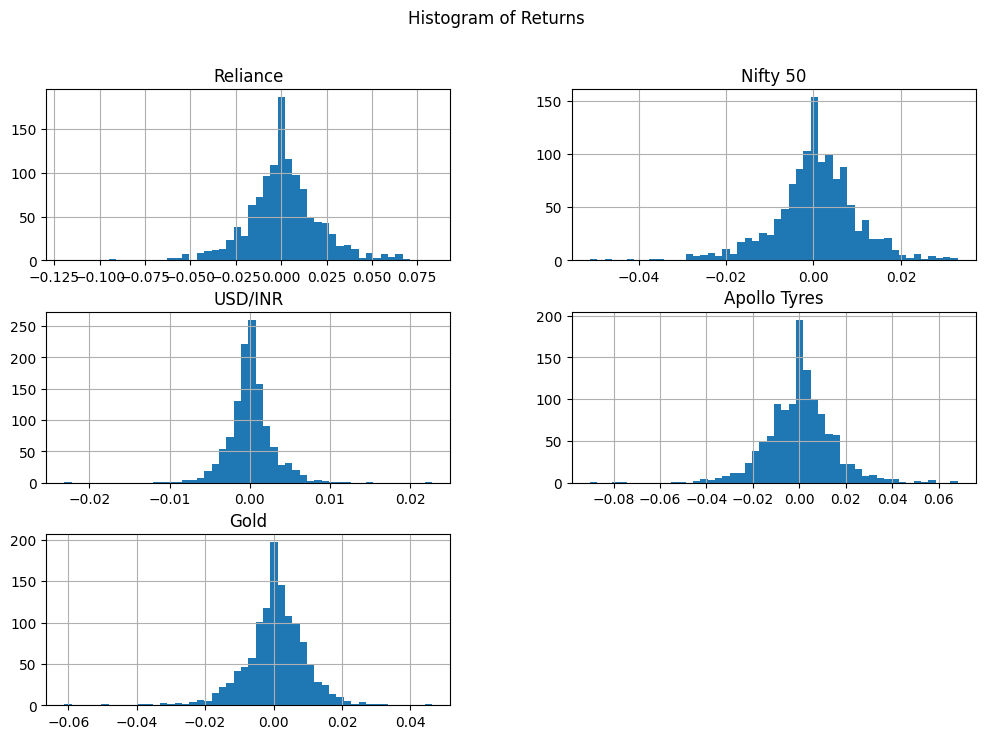

               count      mean       std       min       25%       50%  \
Reliance      1225.0  0.001128  0.020971 -0.119462 -0.009179  0.000000   
Nifty 50      1225.0  0.000431  0.009568 -0.051069 -0.004170  0.000425   
USD/INR       1225.0  0.000133  0.002849 -0.023115 -0.001217  0.000022   
Apollo Tyres  1225.0  0.000306  0.014762 -0.090118 -0.007959  0.000000   
Gold          1225.0  0.000609  0.008973 -0.061124 -0.003676  0.000311   

                   75%       max  skewness  kurtosis  
Reliance      0.011256  0.083148 -0.130664  2.891300  
Nifty 50      0.005994  0.032973 -0.461716  2.325263  
USD/INR       0.001270  0.022756  0.344158  8.716985  
Apollo Tyres  0.007863  0.068245 -0.098578  3.788382  
Gold          0.005876  0.046333 -0.573952  4.148679  


In [ ]:
data.ffill(inplace=True)
returns = np.log(data / data.shift(1)).dropna()
returns.hist(bins=50, figsize=(12, 8))
plt.suptitle("Histogram of Returns")
plt.show()

summary_stats = returns.describe().T
summary_stats['skewness'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
print(summary_stats)

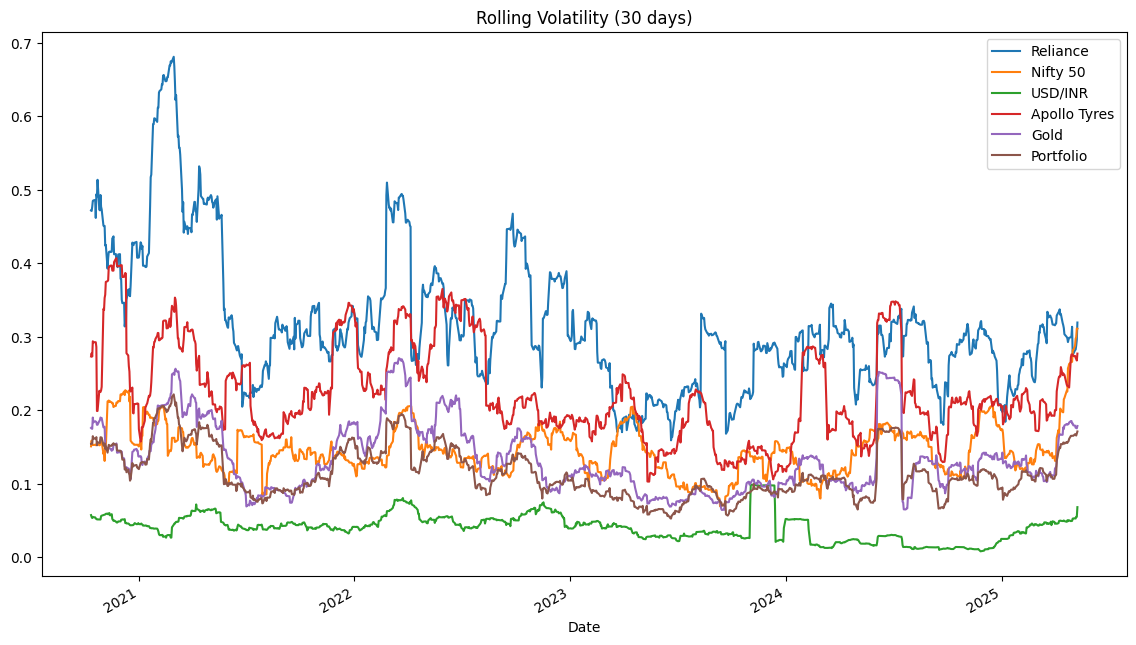

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


GARCH AIC: 5218.123038830778
EGARCH AIC: 5211.660536117346
GARCH BIC: 5238.565823322693
EGARCH BIC: 5232.103320609262


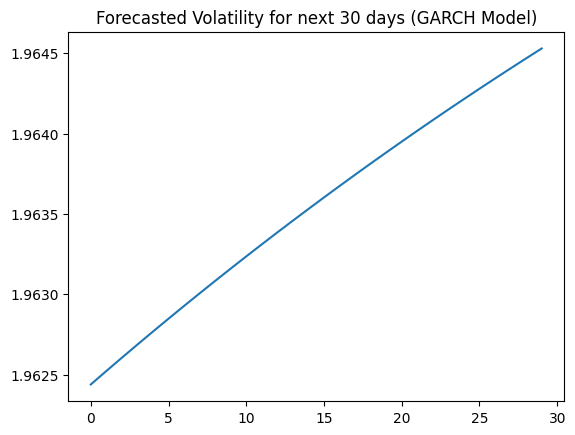

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
returns['Portfolio'] = returns.mean(axis=1)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
rolling_vol.plot(figsize=(14,8), title="Rolling Volatility (30 days)")
plt.show()

# Fit ARIMA model to Reliance returns
arima_model = ARIMA(returns['Reliance'], order=(1,0,1))
arima_result = arima_model.fit()

# Get residuals from ARIMA
residuals = arima_result.resid

# Fit GARCH(1,1) on ARIMA residuals
garch_model = arch_model(residuals * 100, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Fit EGARCH(1,1) on ARIMA residuals
egarch_model = arch_model(residuals * 100, vol='EGarch', p=1, q=1)
egarch_result = egarch_model.fit(disp='off')

# Print AIC and BIC
print("GARCH AIC:", garch_result.aic)
print("EGARCH AIC:", egarch_result.aic)
print("GARCH BIC:", garch_result.bic)
print("EGARCH BIC:", egarch_result.bic)

# Forecast volatility
garch_forecast = garch_result.forecast(horizon=30)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1])

plt.plot(forecast_volatility)
plt.title('Forecasted Volatility for next 30 days (GARCH Model)')
plt.show()

vol_forecasts = {}
for col in returns.columns:
    model = arch_model(returns[col]*100, vol='Garch', p=1, q=1)
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=30)
    vol_forecasts[col] = np.sqrt(forecast.variance.values[-1])

for col in returns.columns:
    model = arch_model(returns[col]*100, vol='EGarch', p=1, q=1)
    res = model.fit(disp='off')

In [ ]:
confidence_levels = [0.95, 0.99]
VaR_results = {}
mean_returns = returns.mean()
std_returns = returns.std()

for cl in confidence_levels:
    VaR_results[f'Variance-Covariance {cl*100}%'] = -(mean_returns - norm.ppf(cl)*std_returns)
for cl in confidence_levels:
    VaR_results[f'Historical {cl*100}%'] = returns.quantile(1-cl)

simulated_returns = np.random.normal(mean_returns, std_returns, (10000, len(returns.columns)))
for cl in confidence_levels:
    VaR_results[f'Monte Carlo {cl*100}%'] = -np.percentile(simulated_returns, (1-cl)*100, axis=0)

VaR_df = pd.DataFrame(VaR_results, index=returns.columns)
print(VaR_df)

              Variance-Covariance 95.0%  Variance-Covariance 99.0%  \
Reliance                       0.033365                   0.047657   
Nifty 50                       0.015306                   0.021827   
USD/INR                        0.004553                   0.006494   
Apollo Tyres                   0.023976                   0.034036   
Gold                           0.014150                   0.020264   
Portfolio                      0.011963                   0.017136   

              Historical 95.0%  Historical 99.0%  Monte Carlo 95.0%  \
Reliance             -0.031427         -0.054962           0.033803   
Nifty 50             -0.016038         -0.026781           0.015452   
USD/INR              -0.004041         -0.006639           0.004611   
Apollo Tyres         -0.022477         -0.037380           0.023822   
Gold                 -0.014210         -0.026218           0.014060   
Portfolio            -0.011411         -0.022025           0.012141   

           

In [ ]:
from scipy.stats import chi2
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kupiec Test for VaR
def kupiec_test(VaR_series, returns, alpha=0.01):
    exceptions = (returns < -VaR_series).sum()
    n = len(returns)
    p_hat = exceptions / n
    LR_uc = -2 * (np.log((1-alpha)**(n-exceptions) * (alpha)**exceptions) - np.log((1-p_hat)**(n-exceptions) * (p_hat)**exceptions))
    return LR_uc

# Christoffersen Test for VaR
def christoffersen_test(VaR_series, returns, alpha=0.01):
    exceptions = (returns < -VaR_series).astype(int)
    n = len(returns)
    p = exceptions.mean()
    # Lag 1 autocorrelation of exceptions
    acf_value = acf(exceptions, fft=True, nlags=1)[1]
    LR_cc = -2 * np.log((1 - acf_value) * ((1-p)**(n - sum(exceptions)) * (p**sum(exceptions))))
    return LR_cc, acf_value

# Ljung-Box test for residuals (GARCH model)
def ljung_box_test(residuals, lags=20):
    lb_stat, p_value = acorr_ljungbox(residuals, lags=lags)
    return lb_stat, p_value

# Backtest for 1-day 99% VaR
VaR_series = -(returns['Portfolio'].mean() - norm.ppf(0.99)*returns['Portfolio'].std())  # VaR at 99%
portfolio_exceptions = (returns['Portfolio'] < -VaR_series).sum()
print("Portfolio 1-day 99% VaR:", VaR_series)
print("Number of exceptions:", portfolio_exceptions)

# Kupiec Test
kupiec_LR_uc = kupiec_test(VaR_series, returns['Portfolio'])
print("Kupiec LR statistic:", kupiec_LR_uc)
print("p-value (Kupiec Test):", 1 - chi2.cdf(kupiec_LR_uc, df=1))

# Christoffersen Test
christoffersen_LR_cc, acf_value = christoffersen_test(VaR_series, returns['Portfolio'])
print("Christoffersen LR statistic:", christoffersen_LR_cc)
print("ACF of exceptions:", acf_value)
print("p-value (Christoffersen Test):", 1 - chi2.cdf(christoffersen_LR_cc, df=1))

# Ljung-Box Test on Residuals (for GARCH model)
lb_stat, p_value = ljung_box_test(residuals)
print("Ljung-Box Statistic:", lb_stat)
print("Ljung-Box p-value:", p_value)

# Interpretation:
# - If p-value < 0.05, reject the null hypothesis and recalibrate the model
# - If p-value > 0.05, the model seems to be valid, but we can further investigate

Portfolio 1-day 99% VaR: 0.017136189780657583
Number of exceptions: 27
Kupiec LR statistic: 13.356917920698606
p-value (Kupiec Test): 0.00025747109522544775
Christoffersen LR statistic: 259.43374542631074
ACF of exceptions: 0.015315800963308698
p-value (Christoffersen Test): 0.0
Ljung-Box Statistic: lb_stat
Ljung-Box p-value: lb_pvalue


In [ ]:
# Simulate GBM paths for Reliance stock for option pricing
n_simulations = 10000
T = 1/252
mu = returns['Reliance'].mean() * 252
sigma = returns['Reliance'].std() * np.sqrt(252)
S0 = data['Reliance'][-1]
np.random.seed(42)
ST = S0 * np.exp((mu - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal(size=n_simulations))

# Option pricing for European call and put options
K = S0
r = 0.06
call_price = np.exp(-r*T) * np.mean(np.maximum(ST - K, 0))
put_price = np.exp(-r*T) * np.mean(np.maximum(K - ST, 0))

# Delta, Gamma, Vega, and Theta estimates using finite differences
dS = 1
S_up = S0 + dS
S_down = S0 - dS
ST_up = S_up * np.exp((mu - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal(size=n_simulations))
ST_down = S_down * np.exp((mu - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal(size=n_simulations))

call_up = np.exp(-r*T) * np.mean(np.maximum(ST_up - K, 0))
call_down = np.exp(-r*T) * np.mean(np.maximum(ST_down - K, 0))

# Delta (finite difference method)
Delta = (call_up - call_down) / (2*dS)

# Gamma (finite difference method)
Gamma = (call_up - 2*call_price + call_down) / (dS**2)

# Option Vega and Theta
# Vega: Sensitivity to volatility (using +/-10% change in sigma)
sigma_up = sigma * 1.1
sigma_down = sigma * 0.9
ST_up_sigma = S0 * np.exp((mu - 0.5*sigma_up**2)*T + sigma_up*np.sqrt(T)*np.random.normal(size=n_simulations))
ST_down_sigma = S0 * np.exp((mu - 0.5*sigma_down**2)*T + sigma_down*np.sqrt(T)*np.random.normal(size=n_simulations))
call_up_sigma = np.exp(-r*T) * np.mean(np.maximum(ST_up_sigma - K, 0))
call_down_sigma = np.exp(-r*T) * np.mean(np.maximum(ST_down_sigma - K, 0))

Vega = (call_up_sigma - call_down_sigma) / (sigma_up - sigma_down)

# Theta: Sensitivity to time decay (using +/-1 day shift)
T_up = T + 1/252
T_down = T - 1/252
ST_up_T = S0 * np.exp((mu - 0.5*sigma**2)*T_up + sigma*np.sqrt(T_up)*np.random.normal(size=n_simulations))
ST_down_T = S0 * np.exp((mu - 0.5*sigma**2)*T_down + sigma*np.sqrt(T_down)*np.random.normal(size=n_simulations))

call_up_T = np.exp(-r*T_up) * np.mean(np.maximum(ST_up_T - K, 0))
call_down_T = np.exp(-r*T_down) * np.mean(np.maximum(ST_down_T - K, 0))

Theta = (call_up_T - call_down_T) / (2 * (1/252))

# Print Greeks
print(f"Call Option Price: {call_price}")
print(f"Put Option Price: {put_price}")
print(f"Delta: {Delta}")
print(f"Gamma: {Gamma}")
print(f"Vega: {Vega}")
print(f"Theta: {Theta}")

Call Option Price: 4.126825529236291
Put Option Price: 3.625832077099354
Delta: 0.5992525718827226
Gamma: 0.034357422777806956
Vega: 10.903257167292177
Theta: 765.5951784793485


/tmp/ipython-input-7-2711954939.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data['Reliance'][-1]


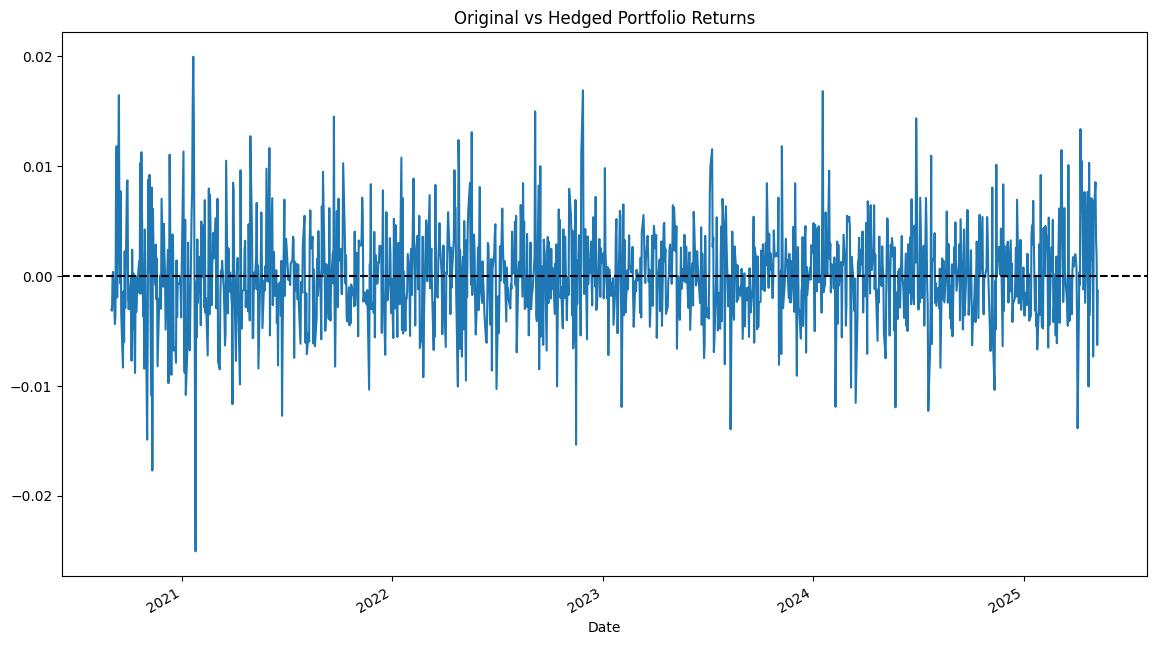

Hedge Ratio: -0.6741062735586022
The hedge ratio suggests how much Gold to buy/sell to offset portfolio risk. By adding a Gold position, we reduce risk exposure to the Portfolio.


In [ ]:
# Delta-Neutral Hedging
portfolio_vol = returns['Portfolio'].std()
gold_vol = returns['Gold'].std()
corr_gold_portfolio = returns.corr().loc['Gold', 'Portfolio']
hedge_ratio = - (corr_gold_portfolio * portfolio_vol) / gold_vol

# Hedged Portfolio
hedged_returns = returns['Portfolio'] + hedge_ratio * returns['Gold']

# Plot the hedged portfolio vs original
hedged_returns.plot(figsize=(14,8), title="Original vs Hedged Portfolio Returns")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Interpretation of the hedging strategy
print(f"Hedge Ratio: {hedge_ratio}")
print("The hedge ratio suggests how much Gold to buy/sell to offset portfolio risk. By adding a Gold position, we reduce risk exposure to the Portfolio.")
